**LangGraph is a tool that helps create agents / smart chatbots by organizing their steps and decisions in a structured way, almost like a flowchart. It makes it easy to control what the chatbot should do next based on the conversation so it feels natural and can handle complex tasks.**

In LangGraph,

We will have Graph(StateGraph), Node , Edge , conditional operator 

``Graph (StateGraph):`` Think of this as a "map" that guides a chatbot through different steps or actions based on specific conditions. It keeps track of what the chatbot has done and decides what it should do next.

``Node:`` Each node represents a single "action" or task in the chatbot, like sending a message or calling a tool. It’s like a stop on the map where the bot completes something.

``Edge:`` Edges are the "paths" between nodes, defining the direction or transition from one action (node) to the next. They tell the bot how to move from one step to another.

``Conditional Operator:`` This operator adds "if-then" rules, letting the bot choose different paths based on the current situation or state. It’s like giving the bot a choice depending on conditions.

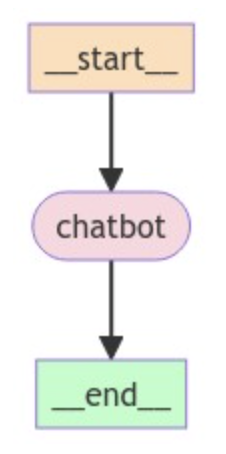

In [38]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, ToolMessage


In [41]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [42]:
llm = ChatOpenAI()

In [43]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


In [44]:
graph_builder.add_node("chatbot", chatbot)


In [45]:
graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

In [46]:
graph = graph_builder.compile()

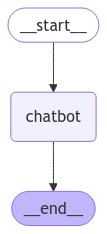

In [47]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [48]:
for event in graph.stream({"messages": [("user", "Hi, My Name is Praveen C")]}):
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: Hello Praveen C! How can I assist you today?


In [49]:
for event in graph.stream({"messages": [("user", "Who directed movie Bahubali")]}):
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: The movie Bahubali was directed by S.S. Rajamouli.


In [50]:
for event in graph.stream({"messages": [("user", "Hi, What My Name")]}):
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: Hello! I'm a language model AI assistant, so I don't have a physical form or a name like humans do. You can just call me Assistant. How can I assist you today?


In [18]:
##################################

In [19]:
_set_env("TAVILY_API_KEY")

In [52]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tool.invoke("What are the places for trekking near hyderabad, Telangana")

[{'url': 'https://www.treebo.com/blog/trekking-places-near-hyderabad/',
  'content': 'Trekking Places near Hyderabad (100 to 200 kilometres) 1. Devarakonda. The Devarakonda fort entrance. Devarakonda is known for its rich cultural heritage that is associated with this region. The place was ruled once ruled by the Velamas dynasty whose remnants can be seen scattered around the area.'},
 {'url': 'https://www.trawell.in/best-trekking-adventure-places-near-hyderabad',
  'content': '10 Best Adventure & Trekking places near Hyderabad. 1. Ahobilam. At a distance of 66 km from Nandyal, 137 km from Kurnool, 114 km from Kadapa, 348 km from Vijayawada, 350 km from Hyderabad and 407 km from Bangalore, Ahobilam or Ahobalam is an important pilgrimage center located in the Kurnool district of Andhra Pradesh.'}]

In [53]:
tools = [tool]

In [54]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI()
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

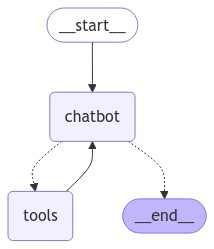

In [55]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [62]:
config = {"configurable": {"thread_id": "1"}}


In [57]:
user_input = "Hi there! My Name is Praveen "

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My Name is Praveen 
================================== Ai Message ==================================

Hello Praveen! How can I assist you today?


In [58]:
user_input = "Hi there! Suggest me one best Mexian Resturant in Hyderabad"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! Suggest me one best Mexian Resturant in Hyderabad
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_etvJADiunOizQm7mpU4FbDLc)
 Call ID: call_etvJADiunOizQm7mpU4FbDLc
  Args:
    query: best Mexican restaurant in Hyderabad
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.tripadvisor.in/Restaurants-g297586-c29-Hyderabad_Hyderabad_District_Telangana.html", "content": "27. Taco Joint. 28. Echoes Living Room. 29. Globally Eat Locally. 30. The Curated Place. Best Mexican Restaurants in Hyderabad, Hyderabad District: Find Tripadvisor traveller reviews of Hyderabad Mexican restaurants and search by price, location, and more."}, {"url": "https://www.dineout.co.in/hyderabad-restaurants/mexican-cuisine", "content": "Check out the list of all b

In [63]:
user_input = "Can you recall my name ?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you recall my name ?
================================== Ai Message ==================================

Yes, your name is Praveen. How can I help you today, Praveen?


In [67]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI()
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

In [68]:
user_input = "What are the best places in Hyderabad, Telangana to spend a day!! "
config = {"configurable": {"thread_id": "1"}}

events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


In [37]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_npGfKAXzJ1Hp9KlNrI8HN8uB)
 Call ID: call_npGfKAXzJ1Hp9KlNrI8HN8uB
  Args:
    query: best places to spend a day in Hyderabad, Telangana


In [39]:
answer = (
    "You can spend a day in Wonderla"
)
new_messages = [
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    AIMessage(content="I would suggest the follwoing :: "+answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    config,
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

I would suggest the follwoing :: You can spend a day in Wonderla


Last 2 messages;
[ToolMessage(content='You can spend a day in Wonderla', id='3b1668a6-a661-4d4b-a2a5-b1252b1bd193', tool_call_id='call_npGfKAXzJ1Hp9KlNrI8HN8uB'), AIMessage(content='I would suggest the follwoing :: You can spend a day in Wonderla', additional_kwargs={}, response_metadata={}, id='e5389725-07b8-431a-938b-1c5a468c0752')]


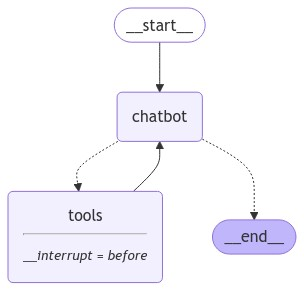

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass